In [85]:
import pandas as pd
import numpy as np
from IPython.display import Image, display
from ipywidgets import IntProgress
from scipy.signal import savgol_filter, firwin, butter, lfilter
from scipy.misc import derivative
import matplotlib.pyplot as plt
import findiff

df_raw = pd.read_csv("./datasets/20A_02.CSV")
df_raw["t"] = df_raw["in s"]
df_raw["Va"] = df_raw["C1 in V"]
df_raw["Ia"] = df_raw["C2 in A"]
df_raw["n"] = df_raw["C3 in V"]

In [86]:
def get_frequency(data, batch_size, time_step):
    fourier = abs(np.fft.fft(data))
    frequencies = np.fft.fftfreq(batch_size, d=time_step)

    half_length = int(frequencies.shape[0]/2)

    arg_max = fourier[1:half_length].argmax()
    max_frequency = frequencies[1:half_length][arg_max]
    return max_frequency

def get_batch(data, label, k, batch_size):
    return data[label].iloc[k*batch_size:(k+1)*batch_size]

In [140]:
data = {
    "t": (df_raw["t"] - df_raw["t"].min()).array,
    "Va": df_raw["Va"].array,
    "Ia": df_raw["Ia"].array,
    "Wm": [],
}
time_step = df_raw["t"].diff().iloc[1]

print("Time step:", time_step)

batch_size = 10000
n = int(df_raw["t"].shape[0]/batch_size)

print("Batches:", n)

f = IntProgress(min=0, max=n) # instantiate the bar
display(f)

num_steps = 2048
start = True
threshold_step = 4

for k in range(n):
    n_batch = get_batch(df_raw, "n", k, batch_size)
    
    step_count = 0
    stepping = False

    for step in n_batch.array:
        if not stepping and step > threshold_step:
            stepping = True
        elif stepping and step < threshold_step:
            stepping = False
            step_count += 1

    W = (step_count / num_steps) / (time_step * batch_size) * 2 * np.pi
    data["Wm"].append(W)

    f.value += 1

data["Wm"] = np.interp(data["t"], data["t"][::batch_size], data["Wm"])

df = pd.DataFrame(data)
df

Time step: 2.399999999985747e-07
Batches: 100


IntProgress(value=0)

,t,Va,Ia,Wm
0,0.000000e+00,0.016113,-0.317383,0.000000
1,2.400000e-07,-0.042480,-0.122070,0.000000
2,4.800000e-07,-0.013184,-0.122070,0.000000
3,7.200000e-07,0.016113,0.024414,0.000000
4,9.600000e-07,0.001465,-0.170898,0.000000
...,...,...,...,...
999995,2.399988e-01,12.086400,1.293950,550.954766
999996,2.399990e-01,12.071800,1.489260,550.954766
999997,2.399993e-01,12.057100,1.245120,550.954766
999998,2.399995e-01,12.013200,1.293950,550.954766


In [141]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
fs = 1/(time_step)    
cutoff = 80

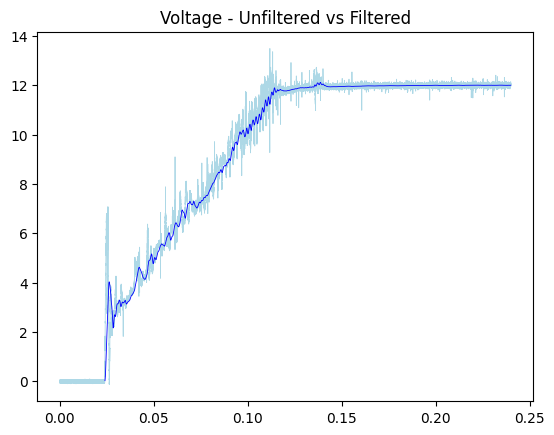

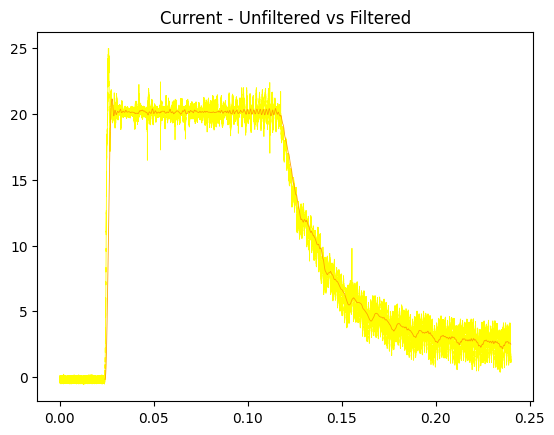

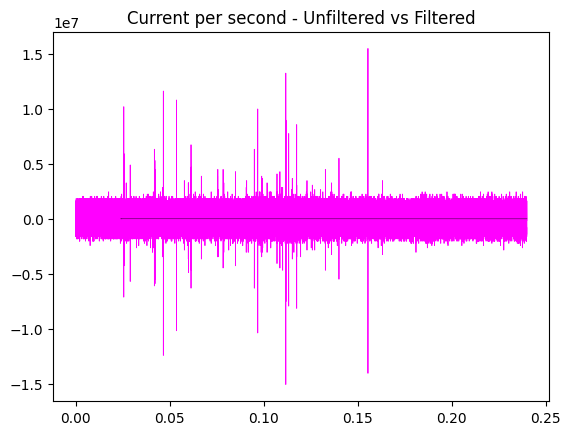

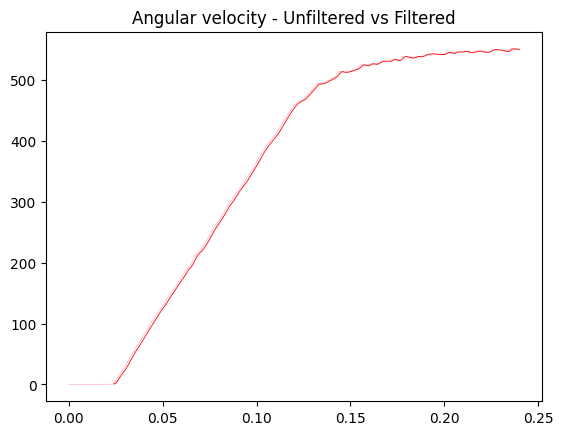

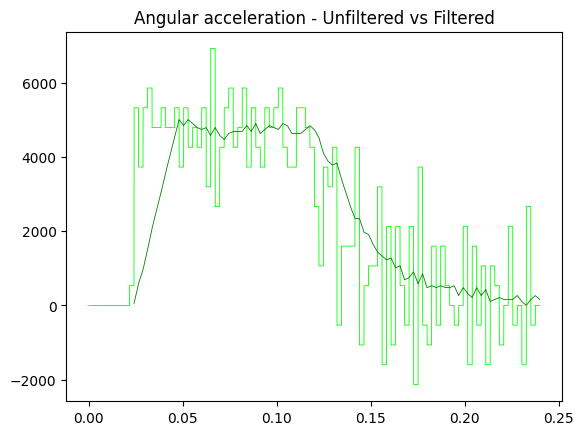

,t,Va,Ia,dIa,Wm,dWm
100000,0.024000,0.025317,-0.176299,203.450417,0.639223,53.263222
100001,0.024000,0.025446,-0.176230,284.830833,0.639351,53.316485
100002,0.024000,0.025570,-0.176182,203.450417,0.639479,53.369748
100003,0.024001,0.025695,-0.176143,162.760417,0.639607,53.423011
100004,0.024001,0.025824,-0.176079,264.485833,0.639735,53.476275
...,...,...,...,...,...,...
999995,0.239999,12.003430,2.500864,-244.137500,550.954766,159.842929
999996,0.239999,12.003434,2.500835,-122.070833,550.954766,159.832276
999997,0.239999,12.003434,2.500777,-244.137500,550.954766,159.821623
999998,0.240000,12.003433,2.500742,-142.412500,550.954766,159.810971


In [142]:
df_filtered = pd.DataFrame()

rolling_width = batch_size
dWm_scalar = 10

df_filtered["t"] = df["t"].iloc[rolling_width*dWm_scalar:]

plt.plot(df["t"], df["Va"], c="lightblue", linewidth=0.6)
df_filtered["Va"] = df["Va"].rolling(rolling_width).mean().iloc[rolling_width*dWm_scalar:]

plt.plot(df_filtered["t"], df_filtered["Va"], c="blue", linewidth=0.6)
plt.title("Voltage - Unfiltered vs Filtered")
plt.show()

plt.plot(df["t"], df["Ia"], c="yellow", linewidth=0.6)
df_filtered["Ia"] = df["Ia"].rolling(rolling_width).mean().iloc[rolling_width*dWm_scalar:]

plt.plot(df_filtered["t"], df_filtered["Ia"], c="orange", linewidth=0.6)
plt.title("Current - Unfiltered vs Filtered")
plt.show()

df["dIa"] = np.concatenate((np.zeros(1), np.diff(np.array(df["Ia"]))/(time_step)))
plt.plot(df["t"], df["dIa"], c="magenta", linewidth=0.6)
df_filtered["dIa"] = df["dIa"].rolling(rolling_width).mean().iloc[rolling_width*dWm_scalar:]

plt.plot(df_filtered["t"], df_filtered["dIa"], c="purple", linewidth=0.6)
plt.title("Current per second - Unfiltered vs Filtered")
plt.show()

plt.plot(df["t"], df["Wm"], c="pink", linewidth=0.6)
df_filtered["Wm"] = df["Wm"].rolling(rolling_width).mean().iloc[rolling_width*dWm_scalar:]

plt.plot(df_filtered["t"], df_filtered["Wm"], c="red", linewidth=0.6)
plt.title("Angular velocity - Unfiltered vs Filtered")
plt.show()

df["dWm"] = np.concatenate((np.zeros(1), np.diff(np.array(df["Wm"]))/(time_step)))
plt.plot(df["t"], df["dWm"], c="lime", linewidth=0.6)
df_filtered["dWm"] = df["dWm"].rolling(rolling_width*dWm_scalar).mean().iloc[rolling_width*dWm_scalar:]

plt.plot(df_filtered["t"], df_filtered["dWm"], c="green", linewidth=0.6)
plt.title("Angular acceleration - Unfiltered vs Filtered")
plt.show()

df_filtered

In [143]:
from math import ceil

def extend_array(data, start=0, end=0):
    return np.concatenate((np.array([data[0]]*start), data, np.array([data[len(data)-1]*end])))

# def central_difference(data, n, time_step):
#     n_edges = ceil((n-1)/2)
#     data_extended = extend_array(data, n_edges, n_edges)
#     d_data = []

#     for i in range(n_edges, n_edges + len(data)):
#         d_i = 0
#         for j in n:
#             d_i += 

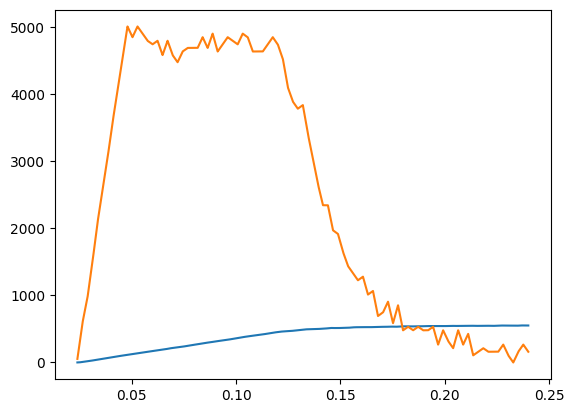

In [154]:
# Circuit Equation  
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Kt*i = TL + Jm*dw/dt + Bm*w

Ra = 0.091
Ke = 18.803 / 1000

t = np.array(df_filtered["t"].array)

Va = np.array(df_filtered["Va"].array)

Ia = np.array(df_filtered["Ia"].array)
dIa = np.array(df_filtered["dIa"].array)

Wm = np.array(df_filtered["Wm"].array)
dWm = np.array(df_filtered["dWm"].array)

TL = 0

plt.plot(t, Wm)
plt.plot(t, dWm)
plt.show()

In [155]:
Xy = np.zeros((3,1))
XX_T = np.zeros((3,3))

# Va - i*Ra - Ke*w = L*di/dt + 0 + 0
# Kt*i - TL = 0 + Jm*dw/dt + Bm*w

n = len(t)

f = IntProgress(min=0, max=int(n/100)) # instantiate the bar
display(f)

for k in range(n):
    y = np.vstack([Va[k] - Ia[k]*Ra - Ke*Wm[k], Ke*Ia[k] - TL])
    X = np.array([
        [dIa[k], 0, 0],
        [0, dWm[k], Wm[k]],
    ])
    Xy += X.T @ y
    XX_T += X.T @ X 
    if k % 100 == 0:
        f.value += 1

print("Batch size:", batch_size)
theta = np.linalg.inv(XX_T) @ Xy
print(theta)

IntProgress(value=0, max=9000)

Batch size: 10000
[[7.77177736e-05]
 [7.92116245e-05]
 [1.69000218e-05]]


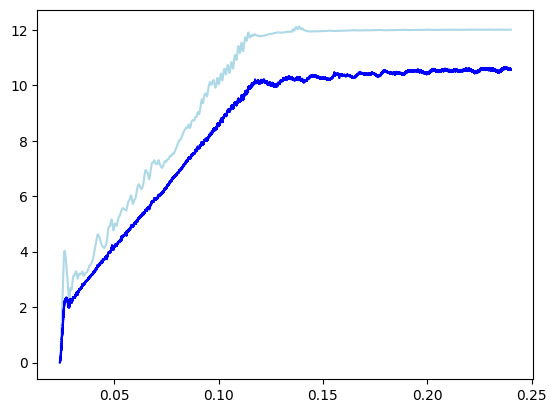

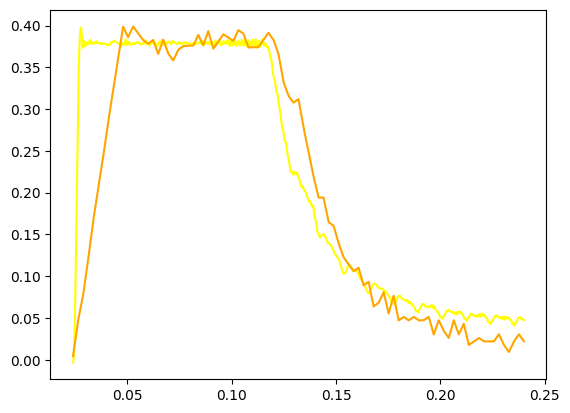

In [156]:
# Circuit Equation  
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Kt*i = TL + Jm*dw/dt + Bm*w
# TL = Kt*i - Jm*dw/dt - Bm*w

La, Jm, Bm = theta.T[0][:3]

Va_pred = Ia*Ra + La*dIa + Ke*Wm
Tm = Ke*Ia
Tm_pred = TL + Jm*dWm + Bm*Wm

plt.plot(t, Va, c="lightblue")
plt.plot(t, Va_pred, c="blue")
plt.show()

plt.plot(t, Tm, c="yellow")
plt.plot(t, Tm_pred, c="orange")
plt.show()